In [2]:
from qiskit import quantum_info as qi
import numpy as np
import pandas as pd
import scipy.linalg as lng
import random as rnd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.1f}'.format

In [3]:
def I0(L):
    label = ""
    for i in range(0,L):
        label += "I"
    return qi.Operator.from_label(label).data

def X(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "X"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Y(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "Y"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Z(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "Z"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data
    
def gx(l,L):
    label = ""
    for i in range(0,l):
        label += "Z"
    label += "X"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def gy(l,L):
    label = ""
    for i in range(0,l):
        label += "Z"
    label += "Y"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def cd(l,L):
    return 1/2*(gx(l,L)+1j*gy(l,L))

def c(l,L):
    return 1/2*(gx(l,L)-1j*gy(l,L))

In [4]:
def bkt(psi_a,U,psi_b):
    return np.dot(np.conjugate(psi_a),np.dot(U,psi_b))

def Mdot(Ol):
    m = Ol[0]
    for i in range(1,len(Ol)):
        m = np.dot(Ol[i],m)
    return m

In [5]:
mu = 0.7

H0 = mu*X(0,1)

In [6]:
print(pd.DataFrame(H0))
e0,y0 = lng.eig(H0)
psi0 = np.conjugate(np.transpose(y0))
print(e0)
psi0[1]

         0        1
0 0.0+0.0j 0.7+0.0j
1 0.7+0.0j 0.0+0.0j
[ 0.7+0.j -0.7+0.j]


array([ 0.70710678-0.j, -0.70710678+0.j])

In [7]:
L0 = int(np.log2(len(H0)))

Hb =-1/2*Z(0,L0+2)

def Hx(cx):
    return cx*(Mdot([X(0,L0+2),X(1,L0+2)])) 

def HR(w):
    w0 = w+1
    L = L0+1
    return (w0*I0(L)+w0*Z(0,L)+np.kron(I0(1),H0)-np.kron(Z(0,1),H0))/2

def H(cx,w):
    return Hb + Hx(cx) + np.kron(I0(1),HR(w))
    

## Using the full exponential

In [10]:
def U(cx,w,t):
    e,psi_d = lng.eig(H(cx,w))
    psi = np.conjugate(np.transpose(psi_d))
    eD = np.diag(e)
    exp = np.exp(1j*e*t)
    expD = np.diag(exp)
    return Mdot([psi,expD,psi_d])

In [11]:
psiA = qi.Statevector.from_label('000').data

wl = [wi*0.01-1.5 for wi in range(0,300)]

t = 200.0
t=5
cx = 0.01
Ns = 100
pl = []
for w in wl:
    psiS = psiA
    psiS = Mdot([U(cx,w,t),psiS])
    pw = bkt(psiS,Z(0,L0+2),psiS)

    pl.append(pw)

C:\Users\jsten\Anaconda3\envs\qiskit20_new\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jsten\Anaconda3\envs\qiskit20_new\lib\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


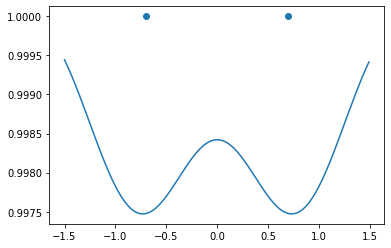

In [12]:
marker = [1 for i in e0]

plt.plot(wl,pl)
plt.scatter(e0,marker)
plt.show()

## Using broken up exponential to match the circuit

$H = -\frac{1}{2} Z_0 + \epsilon_0 I + \epsilon_0 Z_1 + H_0 - Z_1 H_0 +c_x X_0 X_1$

$H_0 = X_2$

$H = -\frac{1}{2} Z_0 + \frac{1}{2}\epsilon_0 I + \frac{1}{2}\epsilon_0 Z_1 + \frac{1}{2}X_2 - \frac{1}{2}Z_1 X_2 +c_x X_0 X_1$

$U(dt) = e^{i(-\frac{1}{2} Z_0 + \frac{1}{2}\epsilon_0 I + \frac{1}{2}\epsilon_0 Z_1 + \frac{1}{2}X_2 - \frac{1}{2}Z_1 X_2 +c_x X_0 X_1)dt} \approx e^{-i\frac{1}{2}Z_0 dt}e^{i \frac{1}{2}\epsilon_0 dt}e^{i \frac{1}{2}\epsilon_0 Z_1 dt}e^{i\frac{1}{2} X_2 dt}e^{-i\frac{1}{2} Z_1 X_2 dt}e^{c_x X_0 X_1 dt}$

or to second order trotterization

$U(2dt) \approx e^{-i\frac{1}{2}Z_0 dt}e^{i \frac{1}{2}\epsilon_0 dt}e^{i \frac{1}{2}\epsilon_0 Z_1 dt}e^{i\frac{1}{2} X_2 dt}e^{-i\frac{1}{2} Z_1 X_2 dt}e^{c_x X_0 X_1 dt}   e^{c_x X_0 X_1 dt}e^{-i\frac{1}{2} Z_1 X_2 dt}e^{i\frac{1}{2} \epsilon_0 Z_1 dt}e^{i\frac{1}{2} X_2 dt}e^{i\frac{1}{2} \epsilon_0 dt}e^{-i\frac{1}{2}Z_0 dt}$

In [12]:
def UT(cx,w,dt):
    L=L0+2
    w0 = w+1
    Ua = np.cos(-1/2*dt)*I0(L) + 1j*np.sin(-1/2*dt)*Z(0,L)
    Ub = np.cos(1/2*w0*dt)*I0(L) + 1j*np.sin(1/2*w0*dt)*I0(L)
    Uc = np.cos(1/2*w0*dt)*I0(L) + 1j*np.sin(1/2*w0*dt)*Z(1,L)
    Ud = np.cos(1/2*mu*dt)*I0(L) + 1j*np.sin(1/2*mu*dt)*X(2,L)
    Ue = np.cos(-1/2*mu*dt)*I0(L) + 1j*np.sin(-1/2*mu*dt)*Mdot([Z(1,L),X(2,L)])
    Uf = np.cos(cx*dt)*I0(L) + 1j*np.sin(cx*dt)*Mdot([X(0,L),X(1,L)])
    return Mdot([Ua,Ub,Uc,Ud,Ue,Uf,Uf,Ue,Ud,Uc,Ub,Ua])

In [13]:
psiA = qi.Statevector.from_label('000').data

wl = [wi*0.03-1.5 for wi in range(0,100)]

cx = 0.1
#t = np.pi/(2*cx)
t = 5
Ns = 100
dt = 1.0
pl = []
for w in wl:
    psiS = psiA
    for ti in range(0,int(t/dt)):
        psiS = Mdot([UT(cx,w,dt/2),psiS])
    pw = bkt(psiS,Z(0,L0+2),psiS)
    print(w,pw)

    pl.append(pw)

-1.5 (0.9453345489115937+0j)
-1.47 (0.9370961382723878+0j)
-1.44 (0.9284151385217031+0j)
-1.41 (0.9193489524353071+0j)
-1.38 (0.9099607309852336+0j)
-1.35 (0.9003186732030068+0j)
-1.32 (0.8904952485424824+0j)
-1.29 (0.8805663516357369+0j)
-1.26 (0.8706104003673247+0j)
-1.23 (0.8607073890759928+0j)
-1.2 (0.8509379094159223+0j)
-1.17 (0.8413821519604875+0j)
-1.1400000000000001 (0.8321189020015606+0j)
-1.1099999999999999 (0.8232245431807587+0j)
-1.08 (0.81477208258215+0j)
-1.05 (0.8068302107176271+0j)
-1.02 (0.7994624094491422+0j)
-0.99 (0.792726120320184+0j)
-0.96 (0.7866719850197001+0j)
-0.93 (0.7813431687852329+0j)
-0.9 (0.7767747764801074+0j)
-0.87 (0.7729933698666881+0j)
-0.8400000000000001 (0.7700165932605574+0j)
-0.81 (0.7678529133069567+0j)
-0.78 (0.7665014770912548+0j)
-0.75 (0.7659520911999678+0j)
-0.72 (0.7661853227109039+0j)
-0.6900000000000001 (0.767172721432034+0j)
-0.66 (0.7688771610530443+0j)
-0.63 (0.7712532952429659+0j)
-0.6000000000000001 (0.7742481231457323+0j)
-0.5700

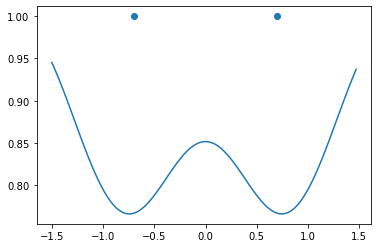

In [14]:
marker = [1 for i in e0]

plt.plot(wl,pl)
plt.scatter(e0,marker)
plt.show()

## Using ZX gates to match pulse

In [42]:
def Rz(phi,l,L):
    return np.cos(phi/2)*I0(L) + 1j*np.sin(phi/2)*Z(l,L)

def Rx(phi,l,L):
    return np.cos(phi/2)*I0(L) + 1j*np.sin(phi/2)*X(l,L)

def Ry(phi,l,L):
    return np.cos(phi/2)*I0(L) + 1j*np.sin(phi/2)*Y(l,L)

def Rzx(phi,l,ll,L):
    return np.cos(phi/2)*I0(L) + 1j*np.sin(phi/2)*Mdot([Z(l,L),X(ll,L)])

def Rxx(phi,l,ll,L):
    return np.cos(phi/2)*I0(L) + 1j*np.sin(phi/2)*Mdot([X(l,L),X(ll,L)])

np.amax(np.abs(Mdot([Ry(np.pi/2,1,3),Rzx(0.5,1,2,3),Ry(-np.pi/2,1,3)])-Rxx(0.5,1,2,3)))

1.1102230246251565e-16

In [44]:
def UP(cx,w,dt):
    L=L0+2
    w0 = w+1
    Ua = Rz(-dt,0,L)
    Uc = Rz(w0*dt,1,L)
    Ud = Rx(mu*dt,2,L)
    Ue = Rzx(-mu*dt,1,2,L)
    Uf = Mdot([Ry(np.pi/2,0,L),Rzx(2*cx*dt,0,1,L),Ry(-np.pi/2,0,L)])
    return Mdot([Ua,Uc,Ud,Ue,Uf,Uf,Ue,Ud,Uc,Ua])

np.amax(np.abs(UT(cx,w,dt)-np.exp(1j*(w+1)*dt)*UP(cx,w,dt)))

5.661048867003676e-16

In [45]:
psiA = np.sqrt(0.2)*qi.Statevector.from_label('000').data
psiA = psiA/np.sqrt(bkt(psiA,I0(L0+2),psiA))
wl = [wi*0.03-1.5 for wi in range(0,100)]

cx = 0.1
#t = np.pi/(2*cx)
t = 5
Ns = 100
#dt = 0.1
dt = 1.0
pl = []
for w in wl:
    psiS = psiA
    for ti in range(0,int(t/dt)):
        psiS = Mdot([UP(cx,w,dt/2),psiS])
    pw = bkt(psiS,Z(0,L0+2),psiS)
    print(w,pw)

    pl.append(pw)

-1.5 (0.9453345489115932+0j)
-1.47 (0.9370961382723895+0j)
-1.44 (0.9284151385217055+0j)
-1.41 (0.9193489524353078+0j)
-1.38 (0.909960730985235+0j)
-1.35 (0.9003186732030095+0j)
-1.32 (0.8904952485424831+0j)
-1.29 (0.8805663516357382+0j)
-1.26 (0.8706104003673271+0j)
-1.23 (0.8607073890759946+0j)
-1.2 (0.8509379094159246+0j)
-1.17 (0.8413821519604903+0j)
-1.1400000000000001 (0.832118902001561+0j)
-1.1099999999999999 (0.82322454318076+0j)
-1.08 (0.8147720825821525+0j)
-1.05 (0.8068302107176263+0j)
-1.02 (0.7994624094491443+0j)
-0.99 (0.7927261203201865+0j)
-0.96 (0.7866719850197049+0j)
-0.93 (0.781343168785233+0j)
-0.9 (0.7767747764801063+0j)
-0.87 (0.7729933698666898+0j)
-0.8400000000000001 (0.7700165932605573+0j)
-0.81 (0.7678529133069569+0j)
-0.78 (0.7665014770912542+0j)
-0.75 (0.7659520911999701+0j)
-0.72 (0.7661853227109071+0j)
-0.6900000000000001 (0.7671727214320381+0j)
-0.66 (0.7688771610530454+0j)
-0.63 (0.7712532952429654+0j)
-0.6000000000000001 (0.7742481231457305+0j)
-0.57000

C:\Users\jsten\Anaconda3\envs\qiskit20_new\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jsten\Anaconda3\envs\qiskit20_new\lib\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


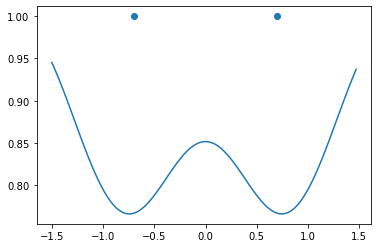

In [46]:
marker = [1 for i in e0]

plt.plot(wl,pl)
plt.scatter(e0,marker)
plt.show()